In [1]:
!pip install h2o

In [2]:
import pandas as pd
import h2o
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as pl

In [3]:
df = pd.read_csv('TOTALNSA.csv', index_col='DATE', parse_dates=True)
df.index.freq='MS'
df.rename(inplace=True, columns={"TOTALNSA":"data"})
df = df.loc['20100101':'20191231']
df.head()

,data
DATE,
2010-01-01,712.469
2010-02-01,793.362
2010-03-01,1083.953
2010-04-01,997.334
2010-05-01,1117.570


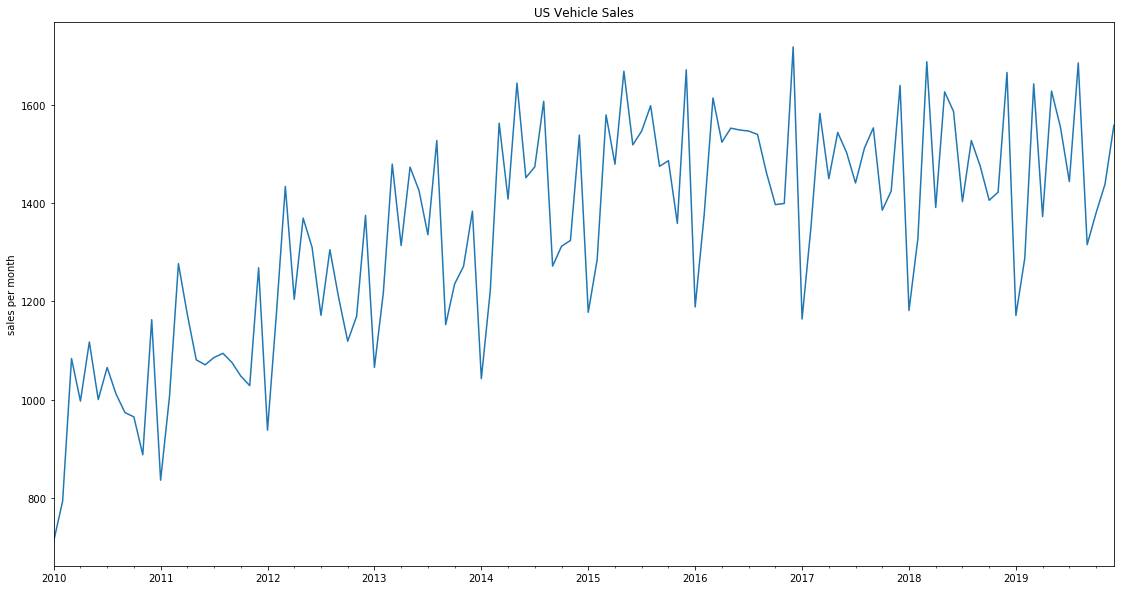

In [4]:
title='US Vehicle Sales'
ylabel='sales per month'
xlabel=''
ax=df.data.plot(figsize=(19,10), title=title)
ax.autoscale(axis='x', tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [5]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; OpenJDK 64-Bit Server VM (build 11.0.6+8-b765.1, mixed mode)
  Starting server from C:\Users\kagiencz\AppData\Local\Continuum\anaconda3\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\kagiencz\AppData\Local\Temp\tmpnvekhjsu
  JVM stdout: C:\Users\kagiencz\AppData\Local\Temp\tmpnvekhjsu\h2o_KAGIENCZ_started_from_python.out
  JVM stderr: C:\Users\kagiencz\AppData\Local\Temp\tmpnvekhjsu\h2o_KAGIENCZ_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,08 secs
H2O_cluster_timezone:,Europe/Berlin
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.0.4
H2O_cluster_version_age:,12 days
H2O_cluster_name:,H2O_from_python_KAGIENCZ_41vjpp
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.857 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


,data,lag12
DATE,,
2010-01-01,712.469,NaN
2010-02-01,793.362,NaN
2010-03-01,1083.953,NaN
2010-04-01,997.334,NaN
2010-05-01,1117.570,NaN
2010-06-01,1000.455,NaN
2010-07-01,1065.748,NaN
2010-08-01,1011.564,NaN
2010-09-01,973.954,NaN


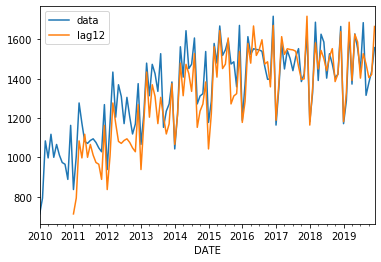

In [6]:
df1 = df.copy()
df1['lag12']=df1.data.shift(12)
display(df1.plot())
df1.head(20)

In [7]:
df1 = df1.dropna()
trend=np.arange(1, len(df1)+1)
trend2=np.square(trend)
df1['trend']=trend
df1['trend2']=trend2
display(df1.head())
df1.tail()

C:\Users\kagiencz\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\kagiencz\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,data,lag12,trend,trend2
DATE,,,,
2011-01-01,836.366,712.469,1,1
2011-02-01,1007.082,793.362,2,4
2011-03-01,1276.843,1083.953,3,9
2011-04-01,1173.520,997.334,4,16
2011-05-01,1081.272,1117.570,5,25


,data,lag12,trend,trend2
DATE,,,,
2019-08-01,1685.339,1527.416,104,10816
2019-09-01,1315.678,1474.997,105,11025
2019-10-01,1380.174,1405.908,106,11236
2019-11-01,1438.444,1422.219,107,11449
2019-12-01,1558.430,1665.906,108,11664


In [8]:
train=h2o.H2OFrame(df1.iloc[:96])
test=h2o.H2OFrame(df1.iloc[96:])
x=['lag12', 'trend', 'trend2']
y='data'

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [9]:
from h2o.estimators import H2ORandomForestEstimator

In [10]:
model = H2ORandomForestEstimator(ntrees=100, max_depth=20, nfolds=5)
model.train(x=x, y=y, training_frame=train)
performance = model.model_performance(test_data=test)
performance

drf Model Build progress: |███████████████████████████████████████████████| 100%

ModelMetricsRegression: drf
** Reported on test data. **

MSE: 15216.902898889864
RMSE: 123.35681131939924
MAE: 100.91128082275388
RMSLE: 0.08711961017364485
Mean Residual Deviance: 15216.902898889864


In [11]:
model = H2ORandomForestEstimator(ntrees=30, max_depth=15, nfolds=3)
model.train(x=x, y=y, training_frame=train)
performance = model.model_performance(test_data=test)
performance

drf Model Build progress: |███████████████████████████████████████████████| 100%

ModelMetricsRegression: drf
** Reported on test data. **

MSE: 10448.088903785174
RMSE: 102.21589359676496
MAE: 82.35101114908854
RMSLE: 0.07228456555970995
Mean Residual Deviance: 10448.088903785174


In [12]:
model = H2ORandomForestEstimator(ntrees=1000, max_depth=100, nfolds=5)
model.train(x=x, y=y, training_frame=train)
performance = model.model_performance(test_data=test)
performance

drf Model Build progress: |███████████████████████████████████████████████| 100%

ModelMetricsRegression: drf
** Reported on test data. **

MSE: 13325.179089725649
RMSE: 115.43473952725691
MAE: 95.0342437744141
RMSLE: 0.08186883536445175
Mean Residual Deviance: 13325.179089725649
